In [18]:
# Authors: Alexandre Barachant <alexandre.barachant@gmail.com>
#
# License: BSD (3-clause)
import numpy as np

from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix

import mne
from mne import io
from mne.datasets import sample

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
print(__doc__)
data_path = sample.data_path()

Automatically created module for IPython interactive environment


In [19]:
# Modificação: Mudança de database utilizada (Atual = exoesqueleto barachant)

#raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw_fname = '../data/record-[2012.07.19-11.24.02]_raw.fif'
#event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
event_fname = '../data/record-[2014.03.10-19.17.37]-eve.fif'

tmin, tmax = -0., 1
# Modificação: Atualização de labels para frequencias
#event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)
event_id = {'steady': 1, '13hz': 2, '17hz': 3, '21hz': 4}

In [20]:
# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir') # replace baselining with high-pass
events = mne.read_events(event_fname)

In [21]:

# Modificação: Retirada de channel MEG, por não tê-lo na novadatabase utilizada
#raw.info['bads'] = ['MEG 2443'] # set bad channels
#picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

picks = mne.pick_types(raw.info, eeg=True, stim=False, eog=False)

In [22]:
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=picks, baseline=None, preload=True, verbose=False)

In [23]:
labels = epochs.events[:, -1]
evoked = epochs.average()

Classification accuracy: 0.281250 


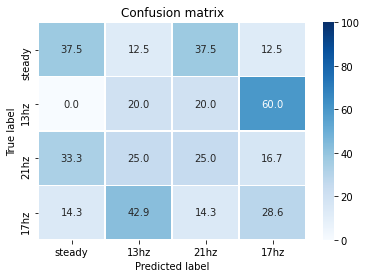

In [24]:
## Decoding in tangent space with a logistic regression

n_components = 2 # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
epochs_data = epochs.get_data()

clf = make_pipeline(XdawnCovariances(n_components), TangentSpace(metric='riemann'), LogisticRegression())

preds = np.zeros(len(labels))

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    clf.fit(epochs_data[train_idx], y_train)
    preds[test_idx] = clf.predict(epochs_data[test_idx])

# Printing the results
acc = np.mean(preds == labels)
print("Classification accuracy: %f " % (acc))

# Modificação: Alteração das labels
#names = ['audio left', 'audio right', 'vis left', 'vis right']
names = ['steady', '13hz', '21hz', '17hz']


plot_confusion_matrix(preds, labels, names)
plt.show()